O algoritmo a seguir fornece uma implementação para monitorar a entropia de Shannon de flags TCP em um fluxo de dados (data stream) em tempo real. Usando dataset rotulado com 5 flgs.

In [11]:
import pandas as pd
import numpy as np
import time
from collections import deque
import matplotlib.pyplot as plt  # Importar matplotlib para criar gráficos


In [12]:
# Função para calcular entropia de Shannon
def calcular_entropia(series):
    """Calcula a entropia de Shannon para uma série categórica."""
    counts = series.value_counts(normalize=True)  # Obter distribuição de probabilidades
    entropy = -np.sum(counts * np.log2(counts + 1e-10))  # Aplicar fórmula de Shannon
    return entropy


def analisar_distribuicao(series):
    """
    Analisa a distribuição de uma série categórica.
    Imprime e retorna o total de amostras, os valores únicos e a contagem de cada valor único.
    """
    # Total de amostras
    total_amostras = len(series)
    
    # Valores únicos e suas contagens
    contagens = series.value_counts()
    valores_unicos = contagens.index.tolist()
    repeticoes = contagens.values.tolist()
    
    # Imprimir informações
    print(f"Total de amostras: {total_amostras}")
    print(f"Valores únicos: {valores_unicos}")
    print(f"Repetições: {repeticoes}")
    
    # Retornar resultados (opcional, caso você ainda precise dos dados)
    return {
        "total_amostras": total_amostras,
        "valores_unicos": valores_unicos,
        "repeticoes": repeticoes
    }


# Classe para monitoramento da entropia em tempo real (Data Stream)
class EntropyMonitor:
    def __init__(self, flags, window_size=100):
        self.flags = flags  # Nomes das colunas (flags TCP)
        self.window_size = window_size  # Tamanho da janela deslizante
        self.stream_data = deque(maxlen=window_size)  # Estrutura para armazenar dados

    def update_stream(self, new_data):
        """Atualiza a janela de dados com novas observações."""
        self.stream_data.append(new_data)

    def calculate_entropy(self):
        """Calcula a entropia das flags TCP dentro da janela de observação."""
        if len(self.stream_data) < 2:  # Evita cálculo com poucos dados
            return {flag: 0 for flag in self.flags}
        
        # Criar DataFrame da janela atual
        stream_df = pd.DataFrame(list(self.stream_data), columns=self.flags)
        
        # Calcular entropia das flags
        entropia_flags = {flag: calcular_entropia(stream_df[flag]) for flag in self.flags}
        return entropia_flags

In [13]:
#=== PASSO 1: Carregar o CSV ===
df = pd.read_csv('dados_rotulados.csv', sep=',')  # Selecionar colunas relevantes

# Extrair colunas relevantes
f1 = df['tcp.flags.ack'].values
f2 = df['tcp.flags.fin'].values
f3 = df['tcp.flags.syn'].values
f4 = df['tcp.flags.urg'].values
f5 = df['tcp.time_delta'].values

# Criar DataFrame com as colunas relevantes
df2 = pd.DataFrame({'tcp.flags.ack': f1, 'tcp.flags.fin': f2, 'tcp.flags.syn': f3, 'tcp.flags.urg': f4, 'tcp.time_delta': f5})

# Limitar a quantia de amostras no dataset.
df2 = df2.head(500)

# Nomes das colunas (flags TCP)
flags = ['tcp.flags.ack', 'tcp.flags.fin', 'tcp.flags.syn', 'tcp.flags.urg', 'tcp.time_delta']

# Criar monitor de entropia para as flags TCP
entropy_monitor = EntropyMonitor(flags, window_size=500)  # Define o tamanho da janela deslizante.
#Quantidade de amostras que serão consideradas de cada vez para calcular a entropia.


In [14]:
print(df2)

     tcp.flags.ack  tcp.flags.fin  tcp.flags.syn  tcp.flags.urg  \
0                0              0              0              0   
1                0              0              1              0   
2                0              0              1              0   
3                0              0              1              0   
4                0              0              1              0   
..             ...            ...            ...            ...   
495              1              0              0              0   
496              1              0              0              0   
497              1              0              0              0   
498              1              0              0              0   
499              1              0              0              0   

     tcp.time_delta  
0          0.000000  
1          0.000000  
2          0.000000  
3          0.000000  
4          0.000000  
..              ...  
495        0.000031  
496        0.003634

In [15]:
# === PASSO 2: Simulação do Data Stream ===
num_iterations = 500  # Número de iterações da simulação
#Simula pacotes (amostras) chegando,e essas amostras sao extraidas do dataset.
#Cada iteração do loop simula a chegada de um novo pacote (ou seja, uma nova amostra é processada).
stream_results = []

print("Monitorando entropia das flags TCP...\n")

for i in range(num_iterations):
    # Simular novos pacotes (extraindo amostras do conjunto de dados original)
    #new_sample = df2.sample(n=1).iloc[0].to_dict() #A mesma amostra pode ser escolhida mais de uma vez.
    #Em cada iteração, uma amostra é escolhida aleatoriamente do df2

    new_sample = df2.iloc[i].to_dict()  #Simula novos pacotes (extraindo amostras em oderm sequencial do dataset)
    entropy_monitor.update_stream(new_sample)
    
    # Calcular a entropia na janela atual
    entropia_atual = entropy_monitor.calculate_entropy()
    
    # Armazenar os resultados do stream
    stream_results.append({"Iteração": i + 1, **entropia_atual})
    
    # Exibir resultados em tempo real
    print(f"Iteração {i+1}: {entropia_atual}")
    
    #Adcionado hj 21/03
    # Analisar a distribuição de cada flag na janela atual
    stream_df = pd.DataFrame(list(entropy_monitor.stream_data), columns=flags)
    distribuicoes = {flag: analisar_distribuicao(stream_df[flag]) for flag in flags}
    
    # Exibir informações da distribuição
    for flag in flags:
        print(f"  Flag: {flag}")
        print(f"    - Total de amostras: {distribuicoes[flag]['total_amostras']}")
        print(f"    - Valores únicos: {distribuicoes[flag]['valores_unicos']}")
        print(f"    - Repetições: {distribuicoes[flag]['repeticoes']}")
    
    # Simular intervalo de tempo entre pacotes
    time.sleep(0.5)  # Ajuste o tempo conforme necessário'
    

Monitorando entropia das flags TCP...

Iteração 1: {'tcp.flags.ack': 0, 'tcp.flags.fin': 0, 'tcp.flags.syn': 0, 'tcp.flags.urg': 0, 'tcp.time_delta': 0}
Total de amostras: 1
Valores únicos: [0.0]
Repetições: [1]
Total de amostras: 1
Valores únicos: [0.0]
Repetições: [1]
Total de amostras: 1
Valores únicos: [0.0]
Repetições: [1]
Total de amostras: 1
Valores únicos: [0.0]
Repetições: [1]
Total de amostras: 1
Valores únicos: [0.0]
Repetições: [1]
  Flag: tcp.flags.ack
    - Total de amostras: 1
    - Valores únicos: [0.0]
    - Repetições: [1]
  Flag: tcp.flags.fin
    - Total de amostras: 1
    - Valores únicos: [0.0]
    - Repetições: [1]
  Flag: tcp.flags.syn
    - Total de amostras: 1
    - Valores únicos: [0.0]
    - Repetições: [1]
  Flag: tcp.flags.urg
    - Total de amostras: 1
    - Valores únicos: [0.0]
    - Repetições: [1]
  Flag: tcp.time_delta
    - Total de amostras: 1
    - Valores únicos: [0.0]
    - Repetições: [1]
Iteração 2: {'tcp.flags.ack': np.float64(-1.442695160185

In [16]:
# === PASSO 3: Criar DataFrame com os resultados do Data Stream ===
stream_df = pd.DataFrame(stream_results)

# Salvar os resultados em um CSV para análise posterior
stream_df.to_csv("entropia_tcp_stream.csv", index=False)

print("\nMonitoramento finalizado! Resultados salvos em 'entropia_tcp_stream.csv'")



Monitoramento finalizado! Resultados salvos em 'entropia_tcp_stream.csv'


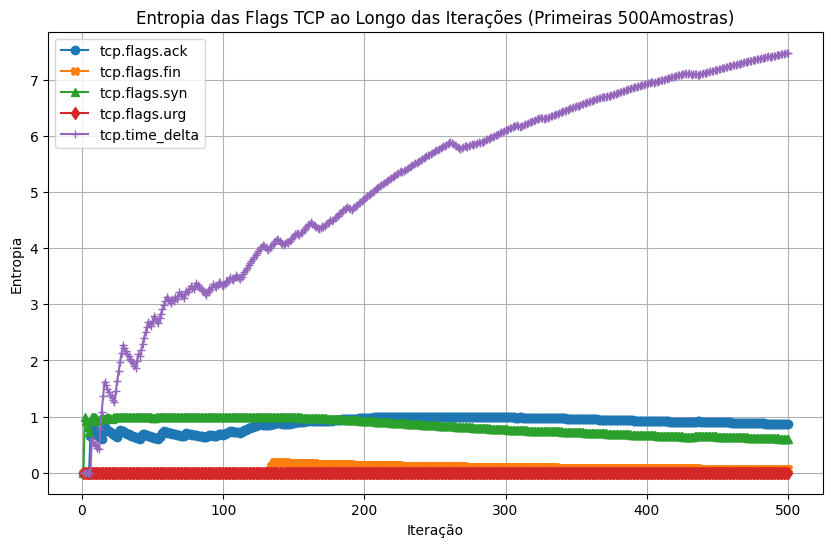

In [17]:
# === PASSO 4: Criar Gráfico ===

# Definir o número de amostras desejadas
num_iterations = 500  # Altere esse valor para controlar quantas amostras serão plotadas

# Preparar os dados para o gráfico
iterations = stream_df['Iteração']
entropia_ack = stream_df['tcp.flags.ack']
entropia_fin = stream_df['tcp.flags.fin']  
entropia_syn = stream_df['tcp.flags.syn']
entropia_urg = stream_df['tcp.flags.urg']
entropia_delta = stream_df['tcp.time_delta']

# Criar o gráfico
plt.figure(figsize=(10, 6))  # Tamanho do gráfico
plt.plot(iterations, entropia_ack, label='tcp.flags.ack', marker='o')
plt.plot(iterations, entropia_fin, label='tcp.flags.fin', marker='X')
plt.plot(iterations, entropia_syn, label='tcp.flags.syn', marker='^')
plt.plot(iterations, entropia_urg, label='tcp.flags.urg', marker='d')
plt.plot(iterations, entropia_delta, label='tcp.time_delta', marker='+')


# Adicionar título e rótulos
plt.title(f'Entropia das Flags TCP ao Longo das Iterações (Primeiras {num_iterations}Amostras)')
plt.xlabel('Iteração')
plt.ylabel('Entropia')
plt.legend()  # Mostrar legenda
plt.grid(True)  # Adicionar grid ao gráfico

# Mostrar o gráfico
plt.show()